In [1]:
from pandas import read_csv, DataFrame
from rdkit import Chem
from rdkit.Chem import PandasTools, AllChem, rdFingerprintGenerator
from rdkit.Chem import Draw
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
import lightgbm
import numpy as np
from numpy import sqrt, array
import shap
import matplotlib.pyplot as plt
from lazypredict.Supervised import LazyRegressor
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.rdCoordGen import AddCoords as addcord
from warnings import filterwarnings
from random import seed
import optuna
import pickle
filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
seed(0)
data = read_csv('../../../DATABASE/no_missing_data.csv')
data

,molecule,smiles,max_abs,max_em,solvent,dc,etn
0,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,445.00,620.00,DMSO,46.83,0.44
1,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,445.00,565.00,H2O,78.36,1.00
2,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,440.00,575.00,AcOEt,6.02,0.23
3,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,450.00,615.00,DCM,8.93,0.31
4,BTD-QN,c4cnc3c(Nc1cccc2nsnc12)cccc3c4,440.00,615.00,ACN,35.69,0.46
...,...,...,...,...,...,...,...
696,Priscila-5,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N(...,380.00,536.00,DCM,8.93,0.31
697,Priscila-5,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N(...,374.00,549.00,ACN,37.50,0.46
698,Priscila-7,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N5...,376.00,570.00,DIOX,2.25,0.16
699,Priscila-7,C(C#Cc1ccc(C#CCN(c2ccccc2)c3ccccc3)c4nsnc14)N5...,377.00,560.00,DCM,8.93,0.31


In [18]:
# seed(0)

# NamesMol = data['molecule']
# SolventMol = data['solvent']

In [ ]:
def prepare_data(data):
    PandasTools.AddMoleculeColumnToFrame(data, 'smiles', 'ROMol')
    radius = 4
    fp_size = 2048
    fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=fp_size)
    morgan_fps = [list(fp_gen.GetFingerprint(m)) for m in data['ROMol']]
    morgan_df = DataFrame(morgan_fps)
    morgan_df.columns = ['MF_' + str(j + 1) for j in morgan_df.columns]
    
    morgan_df['etn'] = data['etn'].to_numpy()

    X_fps = morgan_df.to_numpy()
    y_fps = data['max_abs'].to_numpy()
    
    return X_fps, y_fps

def evaluate_random_state(random_state, X, y):
    model_fps = lightgbm.LGBMRegressor(random_state=42)
    cv_fps = KFold(n_splits=10, shuffle=True, random_state=random_state)
    scores_fps = cross_val_score(model_fps, X, y, scoring='r2', cv=cv_fps, n_jobs=-1).mean()
    return scores_fps, random_state

def find_best_random_state(data, n_states=100):
    X_fps, y_fps = prepare_data(data)
    
    best_score = float('-inf')
    best_random_state = None
    
    print("Random State | Mean R2 Score")
    print("-" * 30)
    
    for random_state in range(n_states):
        score, _ = evaluate_random_state(random_state, X_fps, y_fps)
        print(f"{random_state:12d} | {score:.4f}", flush=True)  # Added flush=True
        
        if score > best_score:
            best_score = score
            best_random_state = random_state
    
    print("-" * 30)
    print(f"Best random state: {best_random_state}")
    print(f"Best mean R2 score: {best_score:.4f}")
    
    return best_random_state, best_score

# Optional: Add a progress bar using tqdm
from tqdm import tqdm

def find_best_random_state_with_progress(data, n_states=100):
    X_fps, y_fps = prepare_data(data)
    
    best_score = float('-inf')
    best_random_state = None
    
    print("Random State | Mean R2 Score")
    print("-" * 30)
    
    for random_state in tqdm(range(n_states), desc="Evaluating random states"):
        score, _ = evaluate_random_state(random_state, X_fps, y_fps)
        print(f"{random_state:12d} | {score:.4f}", flush=True)
        
        if score > best_score:
            best_score = score
            best_random_state = random_state
    
    print("-" * 30)
    print(f"Best random state: {best_random_state}")
    print(f"Best mean R2 score: {best_score:.4f}")
    
    return best_random_state, best_score

# Usage
np.random.seed(0)
# Choose either version:
# best_random_state, best_score = find_best_random_state(data)
best_random_state, best_score = find_best_random_state_with_progress(data)

best random_state RandomForest for abs KFold: 98

best random_state RandomForest for em KFold: 45

In [3]:
seed(0)

np.random.seed(0)


PandasTools.AddMoleculeColumnToFrame(data, 'smiles', 'ROMol')
        # Create the fingerprint generator
fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius = 4, fpSize = 2048)

# Generate fingerprints for each molecule
morgan_fps = [list(fp_gen.GetFingerprint(m)) for m in data['ROMol']]

morgan_df = DataFrame(morgan_fps)

morgan_df.columns = ['MF_' + str(j+1) for j in morgan_df.columns]
morgan_df['etn'] = data['etn'].to_numpy()
# morgan_df['max_abs'] = data['max_abs'].to_numpy()
# morgan_df['max_em'] = data['max_em'].to_numpy()
# morgan['dc'] = data['dc'].values
morgan_df

,MF_1,MF_2,MF_3,MF_4,MF_5,MF_6,MF_7,MF_8,MF_9,MF_10,...,MF_2040,MF_2041,MF_2042,MF_2043,MF_2044,MF_2045,MF_2046,MF_2047,MF_2048,etn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.44
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.00
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.23
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.31
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.31
697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.46
698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.16
699,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.31


In [ ]:
seed(0)
np.random.seed(0)
test = {}

def objective(trial):

    params = { 'max_bin': trial.suggest_int('max_bin', 255, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 100),}

    model = lightgbm.LGBMRegressor(**params)
    cv = KFold(n_splits=10, shuffle=True, random_state=98)

    x_kf = morgan_df.drop(columns=['max_abs']).to_numpy()
    y_kf = morgan_df['max_abs'].to_numpy()

    mse_scores = cross_val_score(model, x_kf, y_kf, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    r2_scores = cross_val_score(model, x_kf, y_kf, scoring='r2', cv=cv, n_jobs=-1)

    mean_mse = -mse_scores.mean()
    mean_r2 = r2_scores.mean()

    test.update({'trial':trial, 'mse':mean_mse, 'r2':mean_r2})

    return mean_mse, mean_r2


study = optuna.create_study(directions=['minimize', 'maximize'])
study.optimize(objective, n_trials=100)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
for i in study.best_trials:
    print(i.params)
    print(i.values)

In [11]:
seed(0)
np.random.seed(0)
# param_abs = {'n_estimators': 522, 'max_depth': 8, 'learning_rate': 0.028564819211536967, 'subsample': 0.8383756107911184, 'colsample_bytree': 0.720080324874693, 'gamma': 0.001754742159327034, 'reg_alpha': 7.710396015328691e-05, 'reg_lambda': 0.09953515181829936, 'min_child_weight': 4}
# param_em = {'n_estimators': 698, 'max_depth': 4, 'learning_rate': 0.03275426841763309, 'subsample': 0.7530528560775489, 'colsample_bytree': 0.7318698494144726, 'gamma': 6.127310380299753e-08, 'reg_alpha': 0.4795336721521944, 'reg_lambda': 0.005848556892914068, 'min_child_weight': 3}

model_pred = lightgbm.LGBMRegressor(verbose=-1)

X = morgan_df.to_numpy()
Y = data['max_em'].to_numpy()

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

kfold = KFold(n_splits=10, random_state=45, shuffle=True)

In [12]:
seed(0)
np.random.seed(0)
for score in scoring:
    if 'neg' in score:     
        scores = cross_val_score(model_pred, X, Y, cv=kfold, scoring=score)
        if 'squared' in score:
            scores = [sqrt(-x) for x in scores]
        else:
            scores = [-x for x in scores]
        mean_scores = np.mean(scores)
        std_scores = np.std(scores)
        print('{}: {:.4f}+-{:.4f}'.format(score, mean_scores, std_scores))

    else:
        scores = cross_val_score(model_pred, X, Y, cv=kfold, scoring=score)
        print('{}: {:.4f}+-{:.4f}'.format(score, scores.mean(), scores.std()))

r2: 0.8583+-0.0511
neg_mean_squared_error: 26.2892+-6.6969
neg_mean_absolute_error: 16.5026+-1.7000


**For max_abs**

r2: 0.8981+-0.0377

neg_mean_squared_error: 14.3505+-3.6646

neg_mean_absolute_error: 8.0827+-1.3499


**For max_em**

r2: 0.8740+-0.0508

neg_mean_squared_error: 21.7825+-3.2040

neg_mean_absolute_error: 14.5597+-1.8141

$Erro = \frac{\sqrt{MSE}}{\bar{Y}}*100$

In [13]:
seed(0)

model_pred.fit(X, Y)

LGBMRegressor(verbose=-1)

In [14]:
error = []

y_preditos = []

for i in range(len(Y)):
    y_expected = Y[i]
    y_pred = model_pred.predict(array(X[i]).reshape(1, -1))

    y_preditos.append(y_pred[0])

    sapato = (abs(y_pred-y_expected)/y_expected)*100

    if sapato > 1 and y_expected > 720:
        print(y_expected)


    error.append(sapato)


erros_brutos = [x for x in error if x > 1]
len(erros_brutos)

752.0
749.0
750.0
786.0
759.0
755.0
805.0
870.0
748.0
825.0
890.0


369

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
import numpy as np
from math import sqrt

residuals = np.abs(Y - np.array(y_preditos))
threshold = 3 * np.std(residuals)
outliers = residuals > threshold

X_clean = X[~outliers]
Y_clean = Y[~outliers]

model_clean = lightgbm.LGBMRegressor(verbose=-1)
kfold_clean = KFold(n_splits=10, random_state=45, shuffle=True)

r2 = []
q2 = []
rmse = []
mae = []

for train_index, test_index in kfold_clean.split(X_clean):
    X_train, X_test = X_clean[train_index], X_clean[test_index]
    Y_train, Y_test = Y_clean[train_index], Y_clean[test_index]
    
    model_clean.fit(X_train, Y_train)
    predictions = model_clean.predict(X_test)

    r2.append(r2_score(Y_test, predictions))
    q2.append(explained_variance_score(Y_test, predictions))
    rmse.append(sqrt(mean_squared_error(Y_test, predictions)))
    mae.append(mean_absolute_error(Y_test, predictions))

print('R2: {:.4f}+-{:.4f}'.format(np.mean(r2), np.std(r2)))
print('Q2: {:.4f}+-{:.4f}'.format(np.mean(q2), np.std(q2)))
print('RMSE: {:.4f}+-{:.4f}'.format(np.mean(rmse), np.std(rmse)))
print('MAE: {:.4f}+-{:.4f}'.format(np.mean(mae), np.std(mae)))

R2: 0.8740+-0.0508
Q2: 0.8763+-0.0488
RMSE: 21.7825+-3.2040
MAE: 14.5597+-1.8141


In [16]:
error = []

y_preditos = []

for i in range(len(Y_clean)):
    y_expected = Y_clean[i]
    y_pred = model_pred.predict(array(X_clean[i]).reshape(1, -1))

    y_preditos.append(y_pred[0])

    sapato = (abs(y_pred - y_expected) / y_expected) * 100

    if sapato > 1 and y_expected > 720:
        print(y_expected)

    error.append(sapato)

erros_brutos = [x for x in error if x > 1]
len(erros_brutos)

755.0
805.0
748.0


348

<Figure size 800x800 with 0 Axes>

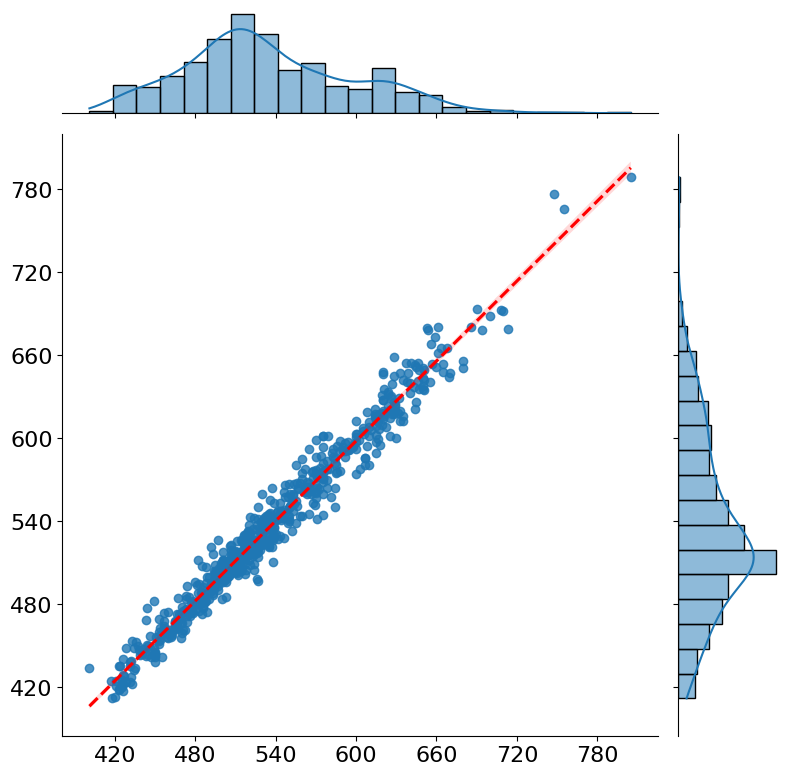

In [17]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator

fig = plt.figure(figsize=(8, 8))
# Create a DataFrame for the expected and predicted values
results_df = DataFrame({'Expected': Y_clean, 'Predicted': y_preditos})

# Create the joint plot with a red regression line
joint_plot = sns.jointplot(x='Expected', y='Predicted', data=results_df, kind='reg', height=8, line_kws={'color': 'red', 'linestyle': '--'})

# Set the number of ticks on x and y axes to 8
joint_plot.ax_joint.xaxis.set_major_locator(MaxNLocator(nbins=8))
joint_plot.ax_joint.yaxis.set_major_locator(MaxNLocator(nbins=8))

# Make the x and y numbers bigger
joint_plot.ax_joint.tick_params(axis='both', which='major', labelsize=16)

# Remove x and y labels
joint_plot.set_axis_labels('', '')

# Save the image
plt.savefig('LGBM_scatter_max_em.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()